In [1]:
import time
import json

import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    Node2VecNodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
import utils

n = 10000
v_sets, e_sets, core_targets, ext_targets, v_sample, e_sample = utils.load_for_jupyter(n)

Dataset already downloaded. Loading it from file system
LOADING DATA: 1.00 s
SUBSAMPLING: 0.06 s
PREPROCESSING: 0.06 s


In [47]:
v_sets['Account']

,Revenue Size Flag,CoreCaseGraphID,ExtendedCaseGraphID,Fraudolent
node_id,,,,
1502001,1,0.0,0.0,0
15020019,5,0.0,0.0,0
15020023,4,0.0,0.0,0
15020024,3,0.0,0.0,0
15020043,1,0.0,0.0,0
...,...,...,...,...
15020148676,2,0.0,0.0,0
15020148714,4,0.0,0.0,0
15020148863,5,0.0,0.0,0


In [3]:
batch_size = 300
epochs = 15
# Use 70% of edges for training, the rest for testing:
train_size = 0.7
test_size = 0.3

In [4]:
# Initialize SG graph
G = sg.StellarDiGraph(v_sets, e_sets)

In [5]:
nodes_with_labels = v_sets.copy()

In [6]:
ext_targets.size

2572

In [7]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 18981, Edges: 10000

 Node types:
  Account: [10916]
    Features: float32 vector, length 4
    Edge types: Account-money transfer->Account, Account-money transfer->Derived Entity
  Customer: [3434]
    Features: float32 vector, length 6
    Edge types: Customer-has account->Account, Customer-has address->Address, Customer-is similar->External Entity
  Derived Entity: [2996]
    Features: float32 vector, length 5
    Edge types: Derived Entity-is similar->External Entity, Derived Entity-money transfer->Account
  External Entity: [1209]
    Features: float32 vector, length 5
    Edge types: none
  Address: [426]
    Features: float32 vector, length 3
    Edge types: none

 Edge types:
    Account-money transfer->Account: [3242]
        Weights: range=[1, 500], mean=177.645, std=222.799
        Features: none
    Customer-has account->Account: [2996]
        Weights: all 1 (default)
        Features: none
    Derived Entity-is similar->External

In [8]:
# Split edges into train and test sets

train_ID, test_ID = model_selection.train_test_split(
    ext_targets, train_size=train_size, test_size=test_size, #stratify=ext_targets
)

In [9]:
# Select only nodes of type "Account" for prediction

train_ID = train_ID[train_ID.index.isin(v_sets['Account'].index)]
test_ID = test_ID[test_ID.index.isin(v_sets['Account'].index)]

In [10]:
# Convert targets labels in one-hot encoded features (optional, for categorical targets)

target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_ID)
test_targets = target_encoding.transform(test_ID)

In [11]:
train_ID.shape

(836, 1)

In [12]:
train_targets.shape

(836, 640)

In [13]:
# Choosing a 2 layer model with 8 nodes sampled in the first layer and 4 in the second.
num_samples = [8, 4]
# we can do 8*4 = 32x32 hidden layer size, since len(num_samples) defines 
# the number of hops (layers) in the HinSAGE model

In [14]:
'''
HinSAGENodeGenerator(G, batch_size, num_samples, head_node_type=None, schema=None, seed=None, name=None)

G = graph
batch_size = size of batch to return
num_samples = the number of samples per layer (hop) to take
head_node_type = the node type that will be given to the generator using the flow method. 
                  The model will expect this type.
                  If not given, it defaults to a single node type.
'''

generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

In [15]:
# Flow

train_gen = generator.flow(train_ID.index, train_targets, shuffle=True)
test_gen = generator.flow(test_ID.index, test_targets)

In [16]:
generator.schema.schema

{'Derived Entity': [EdgeType(n1='Derived Entity', rel='is similar', n2='External Entity'),
  EdgeType(n1='Derived Entity', rel='money transfer', n2='Account')],
 'External Entity': [],
 'Account': [EdgeType(n1='Account', rel='money transfer', n2='Account'),
  EdgeType(n1='Account', rel='money transfer', n2='Derived Entity')],
 'Customer': [EdgeType(n1='Customer', rel='has account', n2='Account'),
  EdgeType(n1='Customer', rel='has address', n2='Address'),
  EdgeType(n1='Customer', rel='is similar', n2='External Entity')],
 'Address': []}

In [17]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

In [18]:
# Dropout
# (must be tuned)

dropout = 0.5

In [19]:
hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'softmax'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

In [20]:
x_inp, x_out = hinsage.in_out_tensors()

In [21]:
def run_deep_graph_infomax(base_model, generator, epochs):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    # Train DGI
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=15)
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    #do TSNE here
    return x_emb_in, x_emb_out, model


Epoch 1/15
37/37 [==============================] - 8s 214ms/step - loss: 0.6156
Epoch 2/15
37/37 [==============================] - 8s 211ms/step - loss: 0.5259
Epoch 3/15
37/37 [==============================] - 8s 215ms/step - loss: 0.4755
Epoch 4/15
37/37 [==============================] - 8s 211ms/step - loss: 0.4523
Epoch 5/15
37/37 [==============================] - 8s 211ms/step - loss: 0.4357
Epoch 6/15
37/37 [==============================] - 8s 208ms/step - loss: 0.4246
Epoch 7/15
37/37 [==============================] - 8s 211ms/step - loss: 0.4100
Epoch 8/15
37/37 [==============================] - 8s 212ms/step - loss: 0.3984
Epoch 9/15
37/37 [==============================] - 8s 213ms/step - loss: 0.3883
Epoch 10/15
37/37 [==============================] - 8s 212ms/step - loss: 0.3763 1s - loss: 0.3 - ETA: 1s - loss: 
Epoch 11/15
37/37 [==============================] - 8s 211ms/step - loss: 0.3700
Epoch 12/15
37/37 [==============================] - 8s 213ms/step - loss

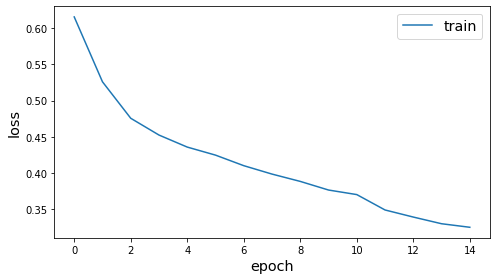

In [22]:
# Run Deep Graph Infomax

x_emb_in, x_emb_out, model = run_deep_graph_infomax(hinsage, generator, epochs=epochs)

In [23]:
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
all_embeddings = emb_model.predict(
    #use a heterogeneous generator...
    generator.flow(G.nodes(node_type="Account"))
)

In [24]:
embeddings_2d = pd.DataFrame(TSNE(n_components=2).fit_transform(all_embeddings), index=G.nodes(node_type="Account"))

In [25]:
embeddings_2d.head()

,0,1
1502001,34.094898,25.234514
15020019,30.116957,-16.849869
15020023,-62.932339,37.770927
15020024,-16.897688,1.725561
15020043,41.995537,3.156867


In [57]:
# Coloring based on ExtendedCaseGraphID
node_ids = G.nodes(node_type="Account").tolist()
ext_targets = v_sample.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID 

label_map = {l: i*10 for i, l in enumerate(np.unique(ext_targets), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets]

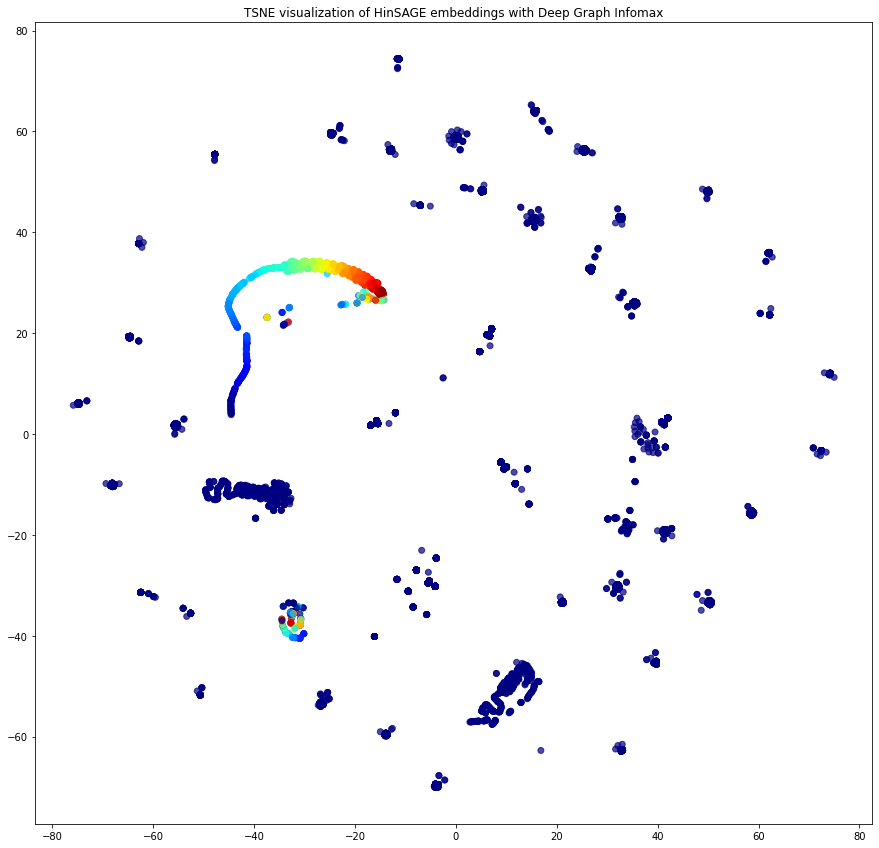

In [58]:
alpha = 0.7


fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    embeddings_2d[0],
    embeddings_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax")
plt.show()

In [96]:
# Coloring based on 'Fraudolent' flag:

ext_fraud = v_sets['Account'].loc[[int(node_id) for node_id in node_ids]].Fraudolent
label_map_fraud = {l: i*10000 for i, l in enumerate(np.unique(ext_fraud.values), start=1) if pd.notna(l)}
node_colours_fraud = [label_map_fraud[target] if pd.notna(target) else 0 for target in ext_fraud]
#node_colours_fraud = ext_fraud.values

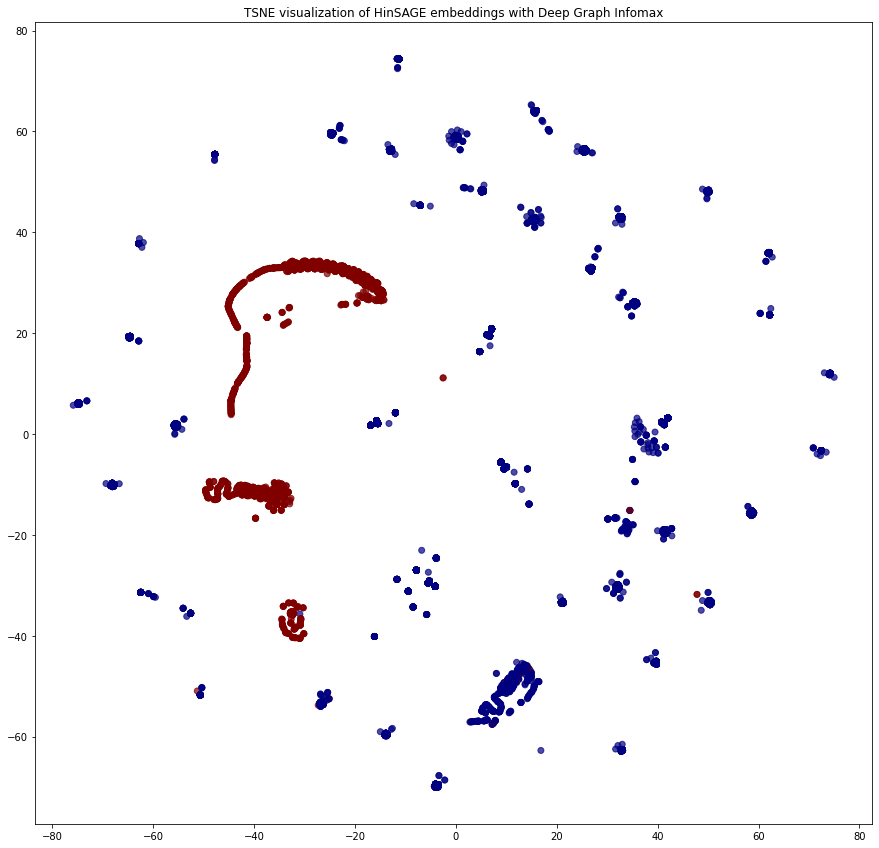

In [98]:
alpha = 0.7


fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    embeddings_2d[0],
    embeddings_2d[1],
    c=node_colours_fraud,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax")
plt.show()

In [29]:
all_embeddings.shape

(10916, 32)

In [30]:
node_ids_full = np.concatenate((
    G.nodes(node_type='Account'), 
    G.nodes(node_type='Customer'), 
    G.nodes(node_type='Derived Entity')
)).tolist()

In [31]:
len(node_ids_full)

17346

In [32]:
len(np.concatenate((
    all_embeddings,
    all_embeddings
)))
#Perfect

21832

# Classification

In [ ]:
# Classify 'Fraudolent' binary class based on embeddings

In [110]:
train_subjects, test_subjects = model_selection.train_test_split(
    ext_fraud, train_size=0.1, test_size=None
)

In [ ]:
# 1 split dataset (v_sets) in training and test set
# 2 obtain embeddings of train and test set (using the already trained infomax results)
# 3 use classifier on train embeddings and corresponding train set.
# 4 evaluate on test set

In [113]:
train_gen = generator.flow(train_subjects.index)
test_gen = generator.flow(test_subjects.index)

train_embeddings = emb_model.predict(train_gen)
test_embeddings = emb_model.predict(test_gen)

In [116]:
lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_subjects)

LogisticRegression()

In [136]:
y_pred = lr.predict(test_embeddings)
acc = (y_pred == test_subjects).mean()
print(f"Test Accuracy on binary fraudolent classification: {acc:.5f}")

Test Accuracy on binary fraudolent classification: 0.99756


In [210]:
# Now I can throw away all the nodes with Fraudolent flag = 0

In [211]:
fraudolent_accounts =pd.DataFrame({'ground_truth':test_subjects, 'predicted':y_pred})
fraudolent_accounts = fraudolent_accounts.loc[fraudolent_accounts['predicted'] == '1']
fraudolent_accounts = fraudolent_accounts.drop(['ground_truth'], axis=1)

In [221]:
fraudolent_accounts.shape

(1561, 1)

In [212]:
# Second part: Classification of fraudolent node embeddings

In [218]:
# Extract IDs of nodes in fraudolent_accounts from ext_targets (since I removed the non-fraudolent nodes)
filter_ext_targets = ext_targets[ext_targets.index.isin(fraudolent_accounts.index.tolist())]

In [220]:
filter_ext_targets.shape

(1561,)

In [229]:
filter_ext_targets.value_counts()

0.0       1388
289.0        2
2285.0       2
1489.0       2
3994.0       2
          ... 
333.0        1
2381.0       1
3183.0       1
2519.0       1
2030.0       1
Name: ExtendedCaseGraphID, Length: 165, dtype: int64

The class imbalance problem was not solved, it was only sized down from 11000 nodes to about 1500.

Now I need to do undersampling and oversampling to train this classifier since the classes are too imbalanced.

-> Attempt #1 : SMOTE (Synthethic Minority Oversampling TEchnique)

In [222]:
train_subjects, test_subjects = model_selection.train_test_split(
    filter_ext_targets, train_size=0.1, test_size=None
)

In [223]:
train_gen = generator.flow(train_subjects.index)
test_gen = generator.flow(test_subjects.index)

train_embeddings = emb_model.predict(train_gen)
test_embeddings = emb_model.predict(test_gen)

In [224]:
lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_subjects)

LogisticRegression()

In [225]:
y_pred = lr.predict(test_embeddings)
acc = (y_pred == test_subjects).mean()
print(f"Test Accuracy on extended ID classification of fraudolent nodes: {acc:.5f}")

Test Accuracy on extended ID classification of fraudolent nodes: 0.88897


In [227]:
np.unique(y_pred)

array([0.])